### discussion, 2/24/2022
Just pushed an updated version of your hmat_dev.ipynb notebook.  I've put in a ton of comments starting with "BJM" just to work on documenting it all for myself and future me.  Important questions are noted with "???".  The biggest question I have is what purpose rmatvec serves for the solver.  It took me a while to figure out what this function was doing!  I'm learning a lot here I cant say enough about how easy you've made this to understand.  I think I can see how to extend this to additional constraint types (e.g., InSAR) based on the structure that you've developed.  At some point I'd definitely like to talk about how to package this for celeri (How many meshes should we do at a time?  Where should rmatvec and matvec be defined?) and about a simple idea to demonstrate this in a relatable way.


Thoughts on the design and how to package this for celeri:
- I think we should do all the meshes at once, since there's no time when you
want to use the linear operator for a single mesh alone.
- I like design below, approximately: 
```
def build_sparse_hmatrix_linear_operator(operators,...):
    sparse_block_motion_okada_faults = ...
    define_other_precomputable_vars_here = ...

    def matvec(v):
        # use vars from the outer scope
    def rmatvec(v):
        # use vars from the outer scope

    return scipy.sparse.linalg.LinearOperator(X.shape, matvec=matvec, rmatvec=rmatvec)
```

## Checking that the H-matrices work!

In the future, we should probably move this to a test in `hmatrix.py`

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import copy
import pickle
import numpy as np
import matplotlib.pyplot as plt
from celeri.hmatrix import build_hmatrix_from_mesh_tdes

with open('hmatrix_dev_data.pkl', 'rb') as f:
   estimation, operators, meshes, segment, station, command, index = pickle.load(f)

## Playing with H-matrices!

In [3]:
H = build_hmatrix_from_mesh_tdes(
    meshes[0], # BJM: Single mesh 
    station, #  BJM: Observation locations.
    operators.meshes[0], # BJM: TDE partials. Need to update this for Jack's new convention
    1e-2, # Tolerance

    # TBT: min_separation is a ratio of the sizes of the two tree nodes. The
    # exact criteria for two nodes being far enough apart that we are allowed to
    # use an approximate matrix block instead of an exact matrix block is:
    # dist > min_separation * (obs_node.radius + src_node.radius)
    min_separation=1.25, #  BJM: What are units here?

    min_pts_per_box=20,
)


(1841, 3) (1841,)


In [4]:
H.report_compression_ratio()

0.12099628019482424

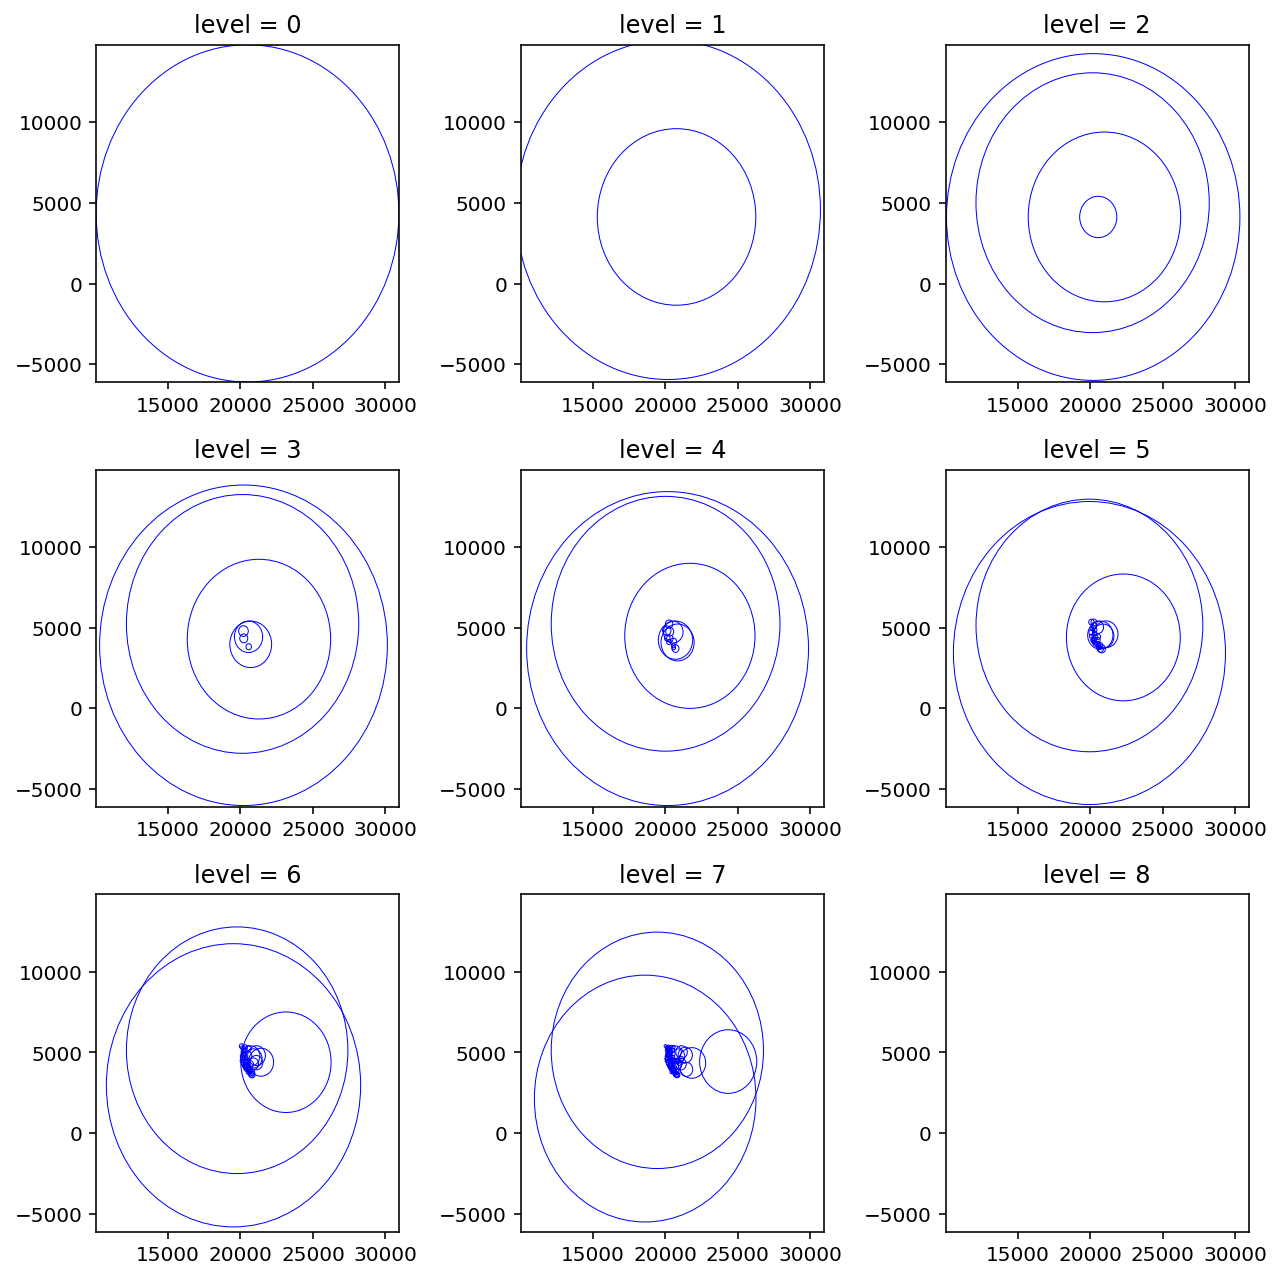

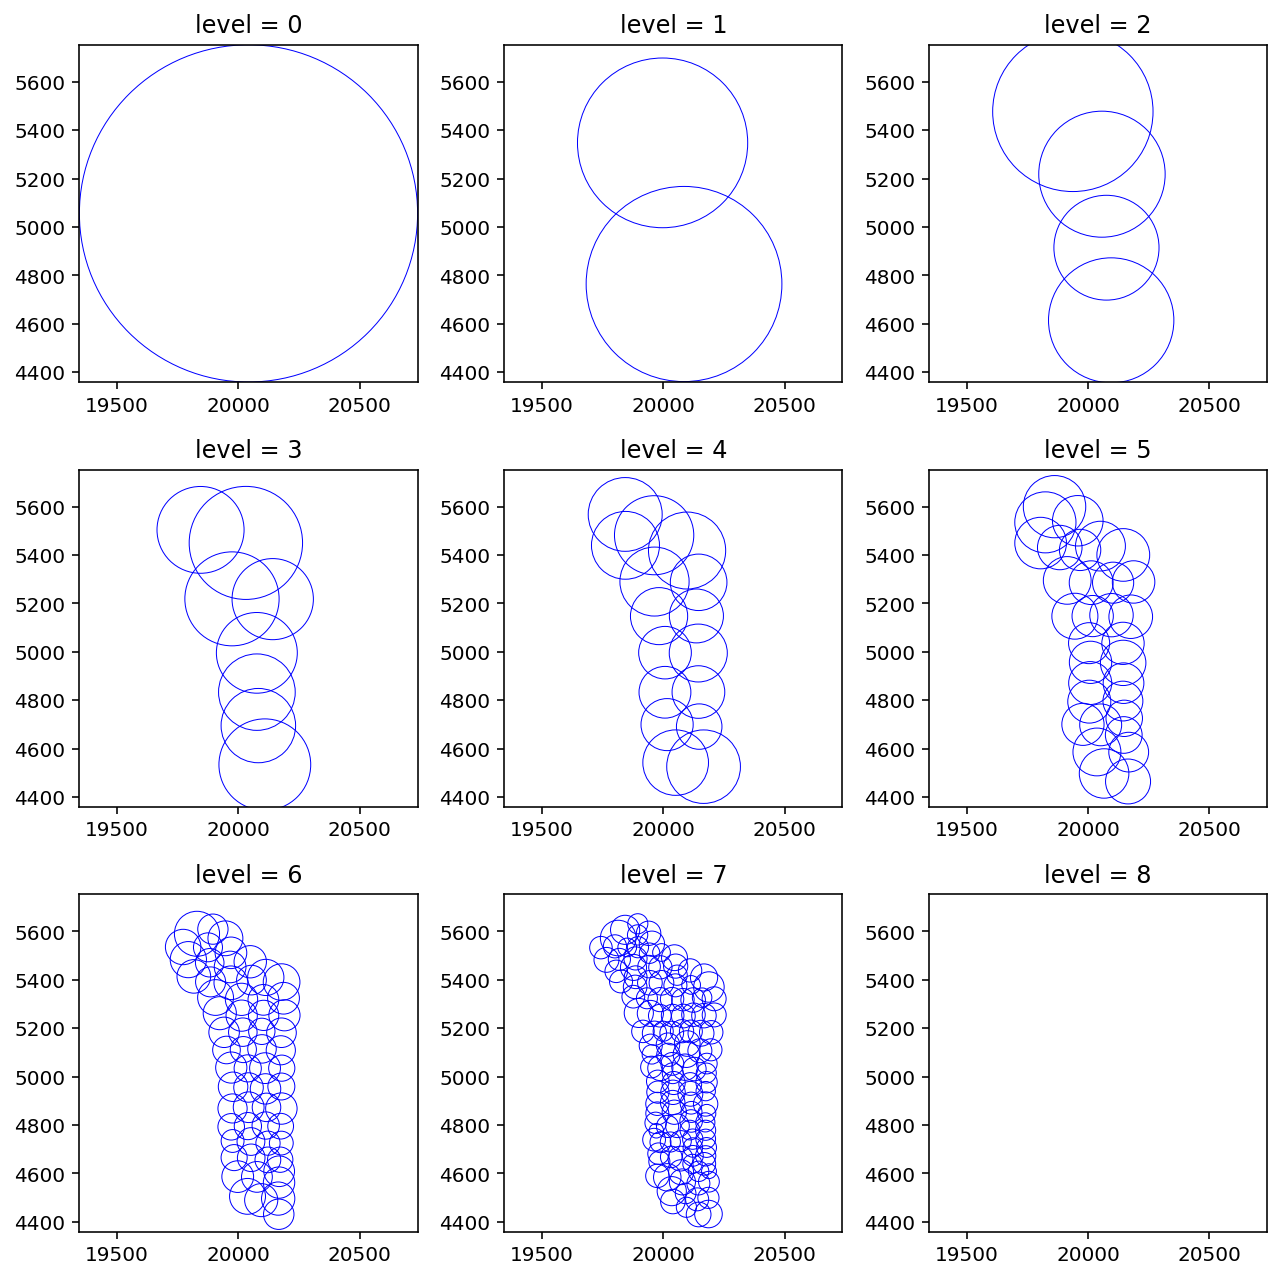

In [5]:
from celeri.hmatrix import plot_tree
plot_tree(H.obs_tree)
plot_tree(H.src_tree)

In [6]:
M = operators.meshes[0].tde_to_velocities
M = np.delete(M, np.arange(2, M.shape[0], 3), axis=0)
M = np.delete(M, np.arange(2, M.shape[1], 3), axis=1)

x = np.random.rand(M.shape[1])
y_true = M.dot(x)

In [7]:
%%time
y_h = H.dot(x)

CPU times: user 3.23 ms, sys: 834 µs, total: 4.06 ms
Wall time: 3.34 ms


/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_42397/3659102695.py:1: RuntimeWarning: divide by zero encountered in log10
  log10err = np.log10(np.abs(y_true - y_h))


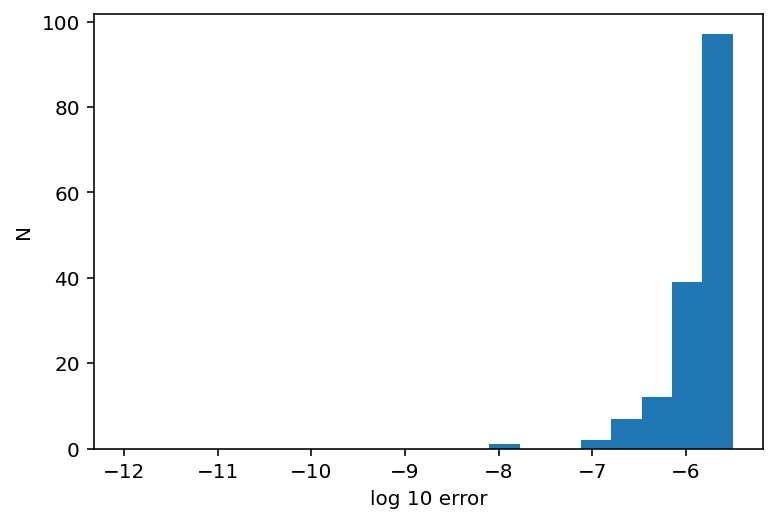

In [8]:
log10err = np.log10(np.abs(y_true - y_h))
plt.hist(log10err, bins=np.linspace(-12,-5.5,21))
plt.ylabel('N')
plt.xlabel('log 10 error')
plt.show()

In [9]:
y = np.random.rand(M.shape[0])
x_true = y @ M

In [10]:

x_h = H.transpose_dot(y)

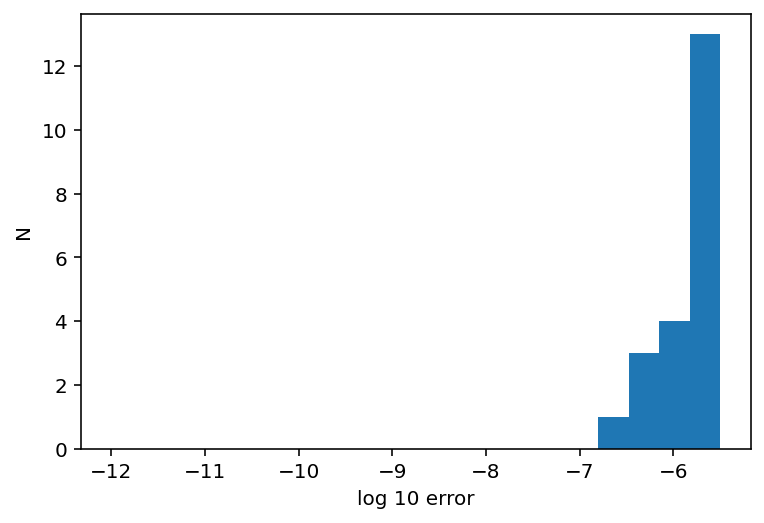

In [11]:
log10errx = np.log10(np.abs(x_true - x_h))
plt.hist(log10errx, bins=np.linspace(-12,-5.5,21))
plt.ylabel('N')
plt.xlabel('log 10 error')
plt.show()

## Playing with iterative solvers.

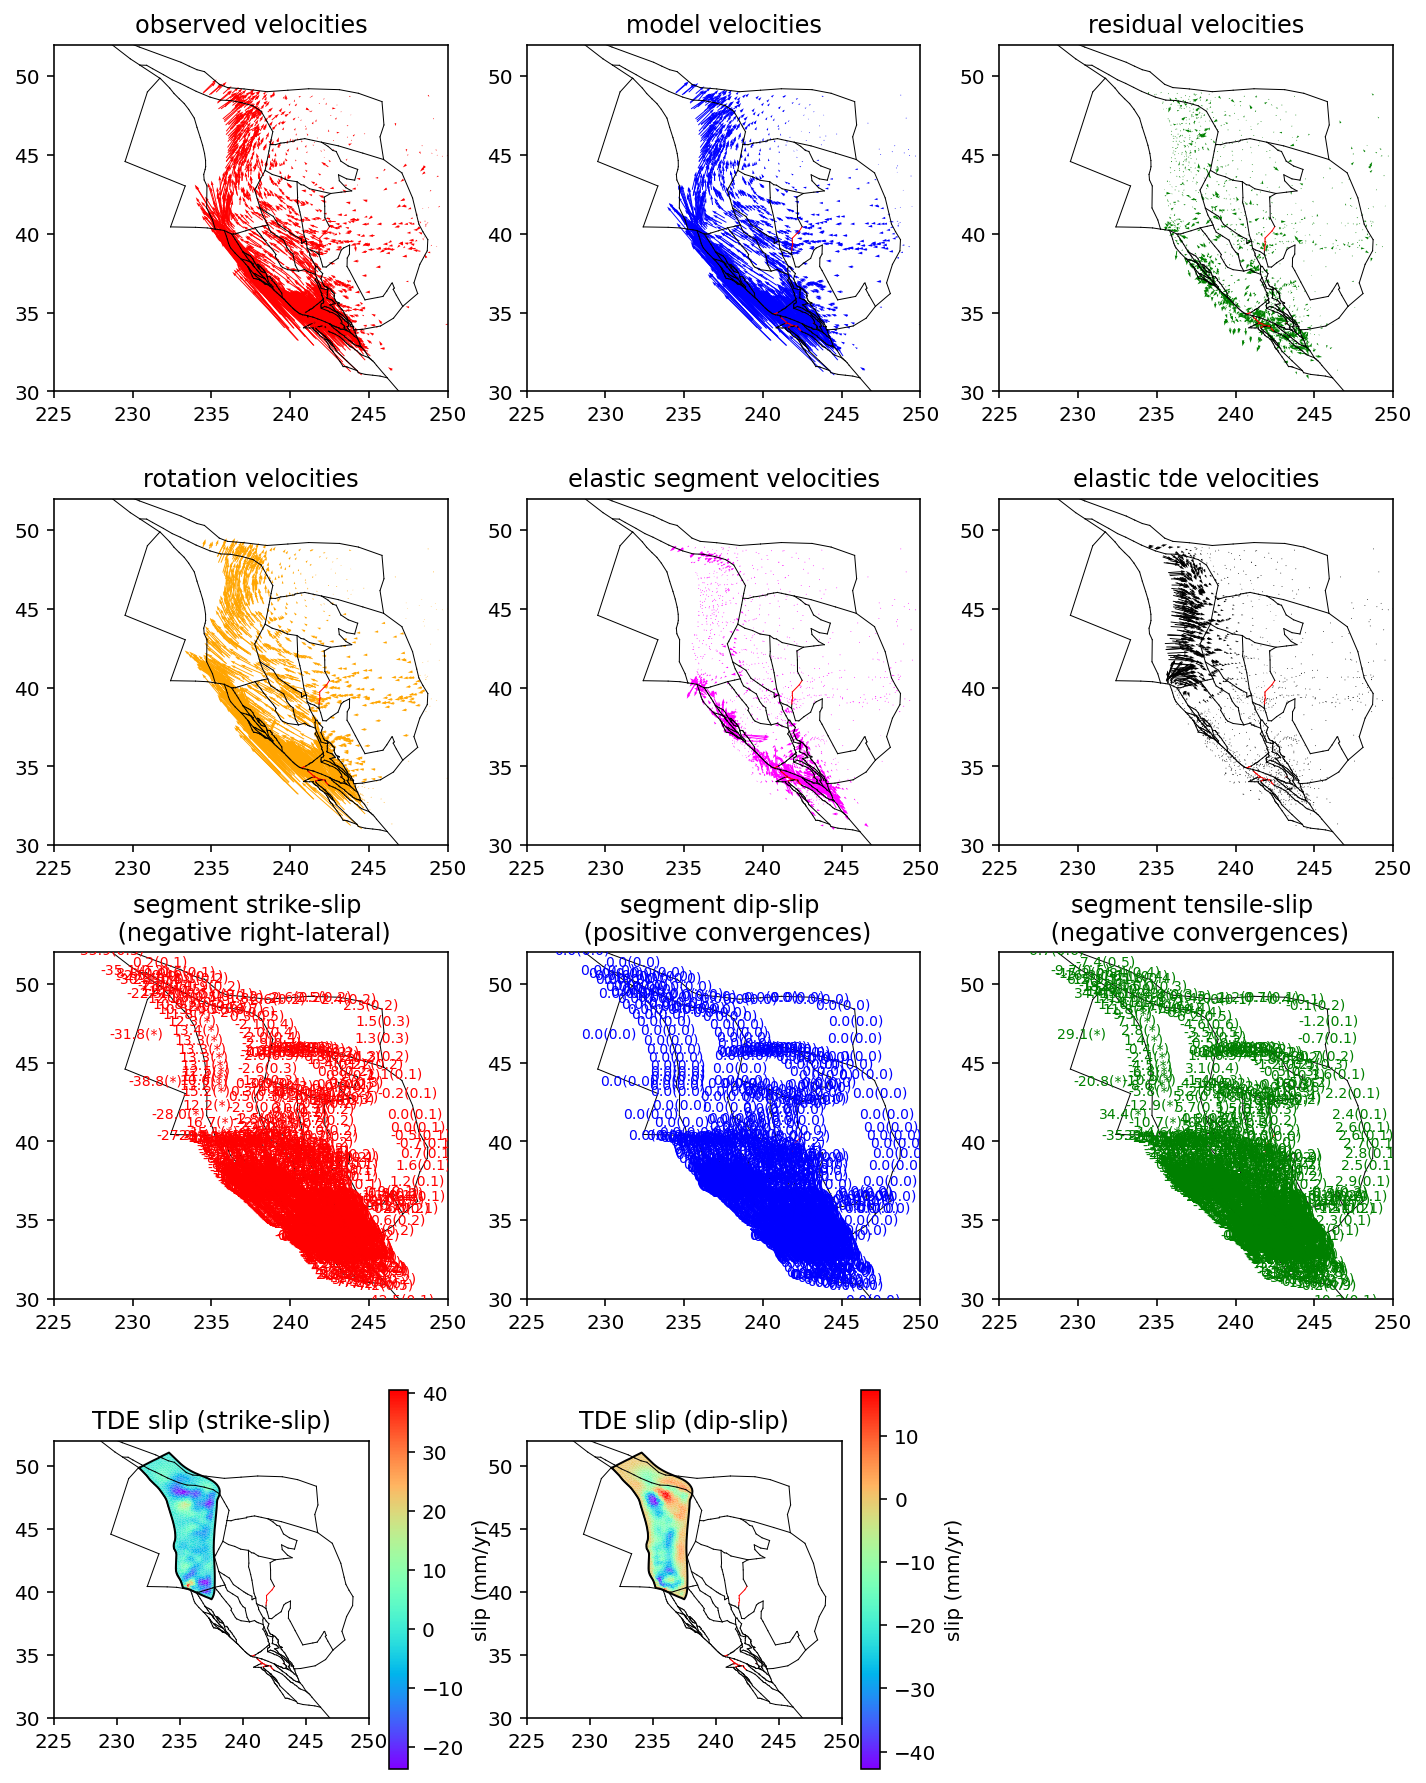

In [12]:
import celeri
# celeri.post_process_estimation(estimation, operators, station, index)
celeri.plot_estimation_summary(segment, station, meshes, estimation, lon_range=(225, 250), lat_range=(30, 52), quiver_scale=1e2)

**weighting**

In [13]:
import scipy.sparse
import scipy.sparse.linalg

W = estimation.weighting_vector
X = estimation.operator
y = estimation.data_vector
Xp = X * np.sqrt(W)[:, None]
yp = y * np.sqrt(W)

**preconditioning**

Scale each column of the data matrix to have a L2 norm of 1.

In [14]:
col_norms = np.linalg.norm(Xp, axis=0)

# BJM: Normalize each column by column norms
XpP = Xp / col_norms[None, :]

In [25]:
# BJM: Iterative dense solution
lsmr_dense = scipy.sparse.linalg.lsmr(XpP, yp, atol=1e-6, btol=1e-6)

# correct the solution for the col_norms preconditioning.
lsmr_dense_soln = lsmr_dense[0] / col_norms

In [26]:
print('exit code: ', lsmr_dense[1])
print('n_iterations: ', lsmr_dense[2])
print('norm(b - Ax): ', lsmr_dense[3])
print('norm(A^H (b - Ax)): ', lsmr_dense[4])
print('norm(A): ', lsmr_dense[5])
print('cond(A): ', lsmr_dense[6])
print('norm(x): ', lsmr_dense[7])

exit code:  2
n_iterations:  890
norm(b - Ax):  168.87787747362475
norm(A^H (b - Ax)):  0.006599409934628982
norm(A):  39.22066400124426
cond(A):  21.014989695239795
norm(x):  6377.109570652349


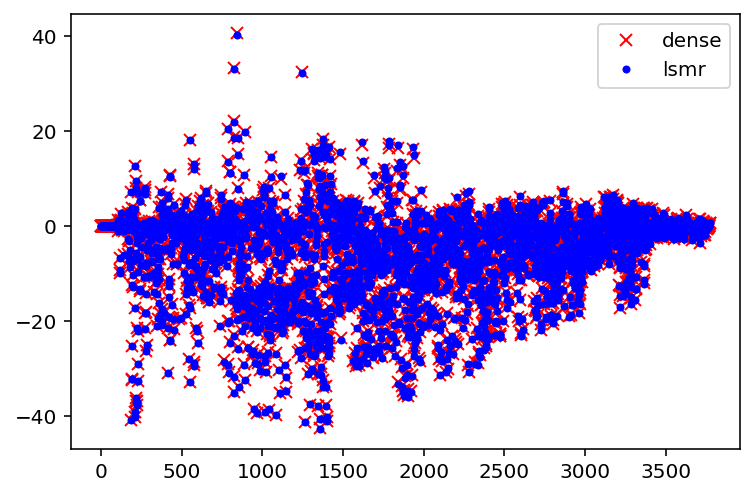

In [27]:
# BJM: Compare iterative dense solution with direct dense solution
plt.figure()
plt.plot(estimation.state_vector, "rx", label="dense")
plt.plot(lsmr_dense_soln, "b.", label="lsmr")
plt.legend()
plt.show()

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_42397/4169005962.py:5: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(relerr),bins=50)


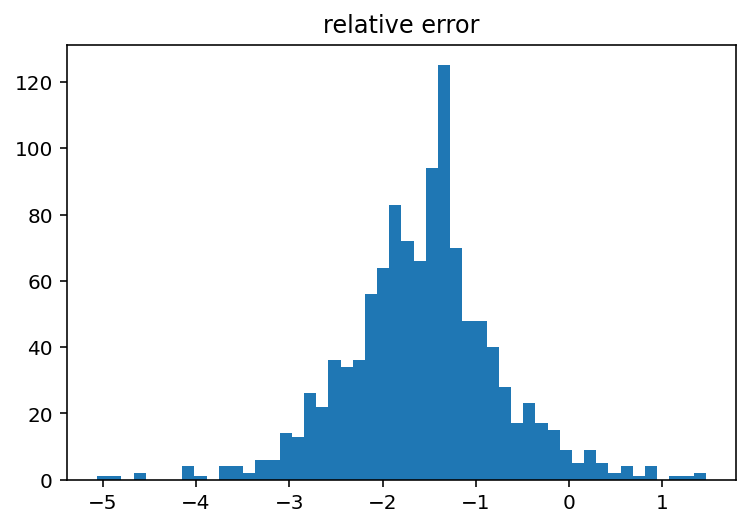

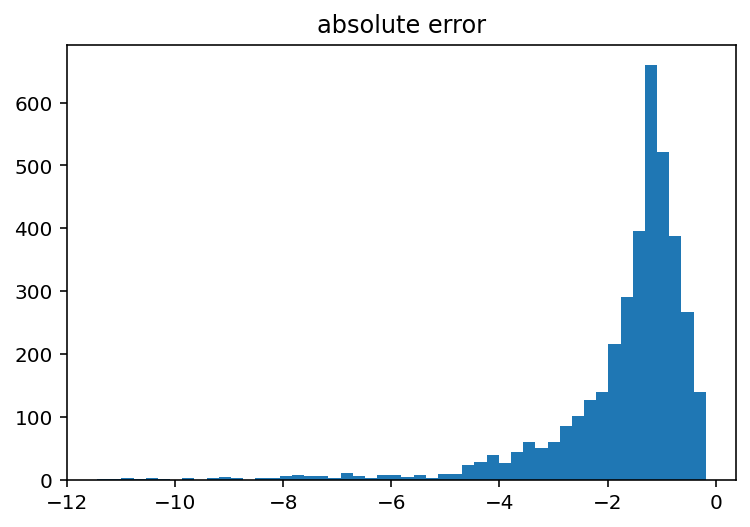

In [28]:
abserr = np.abs(lsmr_dense_soln - estimation.state_vector)
relerr = abserr / estimation.state_vector
plt.figure()
plt.title('relative error')
plt.hist(np.log10(relerr),bins=50)
plt.figure()
plt.title('absolute error')
plt.hist(np.log10(abserr),bins=50)
plt.show()

## Combining H-matrices and iterative solvers

**first check that the sparse component-ized matrix performs the same matvec as the dense version**

In [29]:
from scipy.sparse import csr_matrix
sparse_block_motion_okada_faults = csr_matrix(operators.rotation_to_velocities[index.station_row_keep_index, :] - operators.rotation_to_slip_rate_to_okada_to_velocities[index.station_row_keep_index, :])
sparse_block_motion_constraints = csr_matrix(operators.block_motion_constraints)
sparse_block_slip_rate_constraints = csr_matrix(operators.slip_rate_constraints)

tde_keep_row_index = celeri.get_keep_index_12(operators.meshes[0].tde_to_velocities.shape[0])
tde_keep_col_index = celeri.get_keep_index_12(operators.meshes[0].tde_to_velocities.shape[1])
smoothing_keep_index = celeri.get_keep_index_12(operators.meshes[0].smoothing_matrix.shape[0])
tde_matrix = operators.meshes[0].tde_to_velocities[tde_keep_row_index, :][:, tde_keep_col_index]
sparse_tde_smoothing = csr_matrix(operators.meshes[0].smoothing_matrix[smoothing_keep_index, :][:, smoothing_keep_index])
sparse_tde_slip_rate_constraints = csr_matrix(operators.meshes[0].tde_slip_rate_constraints)

In [30]:
def matvec(v):
    """ BJM: Build matvec (matrix vector product) operator for 
    scipy.sparse.linalg.LinearOperator.  This returns A* u

    BJM: Should we be passing in: W, X, index, etc. or let them be known from the outer scope???
    TBT: This will depend on how we integrate this into celeri and which
    variable we're talking about. For example, we should stop using X.shape
    entirely because that matrix won't exist in a fully sparse/hmatrix
    implementation!
    One design that I would probably lean towards
    would be something like:
    def build_sparse_hmatrix_linear_operator(operators,...):
        sparse_block_motion_okada_faults = ...
        define_other_precomputable_vars_here = ...

        def matvec(v):
            # use vars from the outer scope
        def rmatvec(v):
            # use vars from the outer scope

        return scipy.sparse.linalg.LinearOperator(X.shape, matvec=matvec, rmatvec=rmatvec)
        


    Args:
        u (nd.array): Candidate state vector

    Returns:
        out (nd.array): Predicted data vector
    """

    # BJM: Weight the data vector
    # TBT: It's important to remember to keep the input and output weighting
    # conceptually separate since the "out * np.sqrt(W)" will actually change
    # the solution to the least squares problem whereas the "v / col_norms"
    # preconditioning step is a reversible change to the solution (which is the
    # point since preconditioning should not change the solution!!)
    v_scaled = v / col_norms 

    # BJM: Make storage for output
    out = np.zeros(X.shape[0])

    block_rotations = v_scaled[index.start_block_col : index.end_block_col]
    # okada
    out[
        index.start_station_row : index.end_station_row
    ] += sparse_block_motion_okada_faults.dot(block_rotations)

    # block motion constraints
    out[
        index.start_block_constraints_row : index.end_block_constraints_row
    ] += sparse_block_motion_constraints.dot(block_rotations)

    # slip rate constraints
    out[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row
    ] += sparse_block_slip_rate_constraints.dot(block_rotations)

    tde_velocities = v_scaled[index.meshes[0].start_tde_col : index.meshes[0].end_tde_col]

    # Insert TDE to velocity matrix
    out[index.start_station_row : index.end_station_row] += H.dot(tde_velocities)

    # TDE smoothing
    out[
        index.meshes[0].start_tde_smoothing_row : index.meshes[0].end_tde_smoothing_row
    ] += sparse_tde_smoothing.dot(tde_velocities)

    # TDE slip rate constraints
    out[
        index.meshes[0].start_tde_constraint_row :
        index.meshes[0].end_tde_constraint_row
    ] += sparse_tde_slip_rate_constraints.dot(tde_velocities)

    # Weight!
    return out * np.sqrt(W)

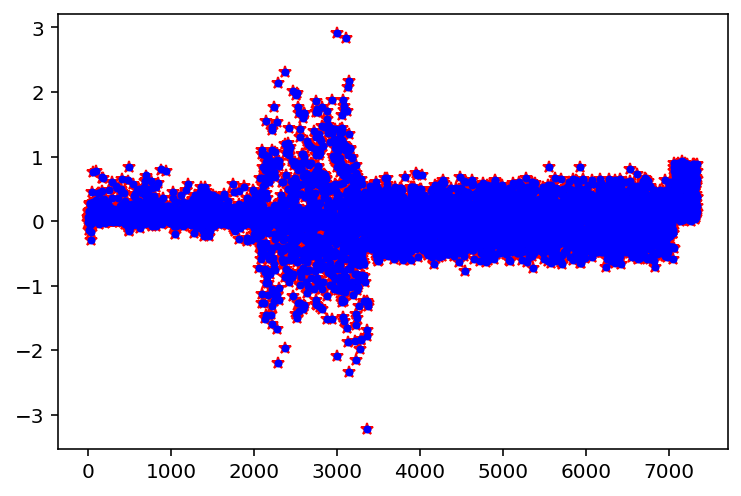

In [31]:
# BJM: Compare dense matrix vector with matvec matrix vector product
rand_vec = np.random.rand(X.shape[1])
y1 = XpP.dot(rand_vec)
y2 = matvec(rand_vec)
plt.plot(y1, 'r*', label='dense')
plt.plot(y2, 'b.', label='sparse')
plt.show()

In [32]:
def rmatvec(u):
    """ BJM: Build rmatvec (matrix vector product) operator for 
    scipy.sparse.linalg.LinearOperator.  This returns:
    Returns A^H * v, where A^H is the conjugate transpose of A
    for a candidate state vector, u.

    BJM: Should we be passing in: W, X, index, etc. or let them be known from the outer scope???
    TBT: See the comment on the same question in matvec.

    BJM: What purpose does rmatvec serve in scipy.sparse.linalg.LinearOperator???
    TBT: When solving a least squares problem, you need to be able to do
    transpose matrix vector products like `A.T.dot(x)`. But, we don't have
    access to the full original matrix, so instead we need to use this rmatvec
    function!

    Args:
        u (nd.array): Candidate state vector

    Returns:
        out (nd.array): Predicted data vector
    """

    # BJM: Weight the data vector
    u_weighted = u * np.sqrt(W)

    # BJM: Storage for output
    out = np.zeros(X.shape[1])

    # BJM: Select subset of weighted data for the observed velocities
    station_rows = u_weighted[index.start_station_row : index.end_station_row]
    block_constraints = u_weighted[
        index.start_block_constraints_row : index.end_block_constraints_row
    ]

    # BJM: Select subset of weighted data for the fault slip rate constraints
    slip_rate_constraints = u_weighted[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row
    ]

    # BJM: Select subset of weighted data for the TDE smoothing
    tde_smoothing = u_weighted[
        index.meshes[0].start_tde_smoothing_row : index.meshes[0].end_tde_smoothing_row
    ]

    # BJM: Select subset of weighted data for the TDE slip rate constraints
    tde_slip_rate = u_weighted[
        index.meshes[0].start_tde_constraint_row :
        index.meshes[0].end_tde_constraint_row
    ]

    # BJM: Okada and block rotation contribution to data vector
    out[index.start_block_col : index.end_block_col] += station_rows @ sparse_block_motion_okada_faults

    # BJM: Block motion constraints contribution to data vector
    out[index.start_block_col : index.end_block_col] += block_constraints @ sparse_block_motion_constraints

    # BJM: Fault slip rate constraints contribution to data vector
    out[index.start_block_col : index.end_block_col] += slip_rate_constraints @ sparse_block_slip_rate_constraints

    # BJM: Hmatrix (TDEs to velocities)
    out[index.meshes[0].start_tde_col : index.meshes[0].end_tde_col] += H.transpose_dot(station_rows)

    # BJM: TDE smoothing contribution to data vector
    out[index.meshes[0].start_tde_col : index.meshes[0].end_tde_col] += tde_smoothing @ sparse_tde_smoothing

    # BJM: TDE slip rate constraint contributions to data vector
    out[index.meshes[0].start_tde_col : index.meshes[0].end_tde_col] += tde_slip_rate @ sparse_tde_slip_rate_constraints

    # Weight!
    return out / col_norms

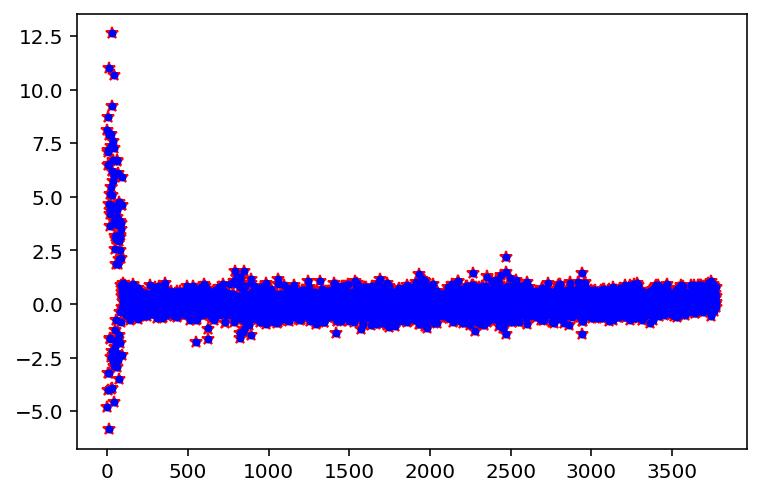

In [33]:
# BJM: Testing that the rmatvec matrix vector product???
# TBT: Yes.
rand_vec = np.random.rand(X.shape[0])
y1 = rand_vec.dot(XpP)
y2 = rmatvec(rand_vec)
plt.plot(y1, 'r*', label='dense')
plt.plot(y2, 'b.', label='sparse')
plt.show()

## Solve with H-matrix/sparse!

In [34]:
# BJM: Create a linear operator the includes the hmatrix vector multiply
op = scipy.sparse.linalg.LinearOperator(X.shape, matvec=matvec, rmatvec=rmatvec)

In [47]:
# BJM: How do "atol" and "btol" relate to "tol" that's passed to "build_hmatrix_from_mesh_tdes" above???
# TBT: They are unrelated. There are two approximations here:
# 1. The H-matrix approximation. This corresponds to the `tol` passed to `build_hmatrix_from_mesh_tdes`.
# 2. The iterative linear solver. The tolerances for this are here. I
# intentionally used very tight tolerances just to minimize the error coming
# from the lsmr solver. Below, I tried change the atol/btol to 1e-6 and the
# solution still looks good and runs about 3x faster than using 1e-13.
#
# You can see the exact meaning of atol and btol in the lsmr docs which I copied
# below: If Ax = b seems to be consistent, lsmr terminates when 
# norm(r) <= atol * norm(A) * norm(x) + btol * norm(b). 
# Otherwise, lsmr terminates when:
# norm(A^H r) <= atol * norm(A) * norm(r).
lsmr_sparse = scipy.sparse.linalg.lsmr(op, yp, atol=1e-6, btol=1e-6)

# Correct the solution for the col_norms preconditioning.
lsmr_sparse_soln = lsmr_dense[0] / col_norms

In [48]:
print('exit code: ', lsmr_sparse[1])
print('n_iterations: ', lsmr_sparse[2])
print('norm(b - Ax): ', lsmr_sparse[3])
print('norm(A^H (b - Ax)): ', lsmr_sparse[4])
print('norm(A): ', lsmr_sparse[5])
print('cond(A): ', lsmr_sparse[6])
print('norm(x): ', lsmr_sparse[7])

exit code:  2
n_iterations:  888
norm(b - Ax):  168.87889388173753
norm(A^H (b - Ax)):  0.006595521919414212
norm(A):  39.113092613732704
cond(A):  21.32478371042816
norm(x):  6379.7349513090885


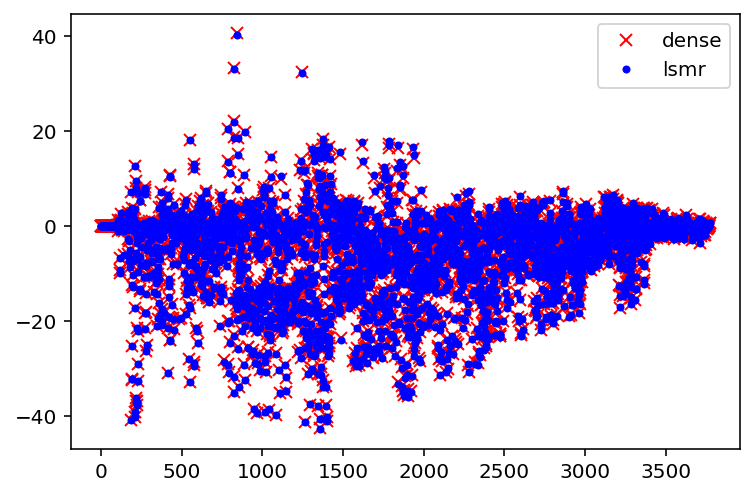

In [40]:
# BJM: Compare sparse hmatrix and direct block model solutions
plt.figure()
plt.plot(estimation.state_vector, "rx", label="dense")
plt.plot(lsmr_sparse_soln, "b.", label="lsmr")
plt.legend()
plt.show()

/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_55738/2263015544.py:5: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(relerr),bins=50)


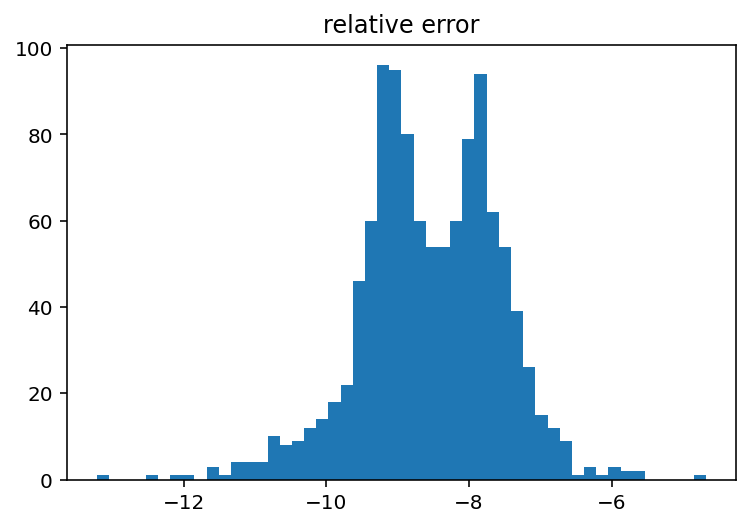

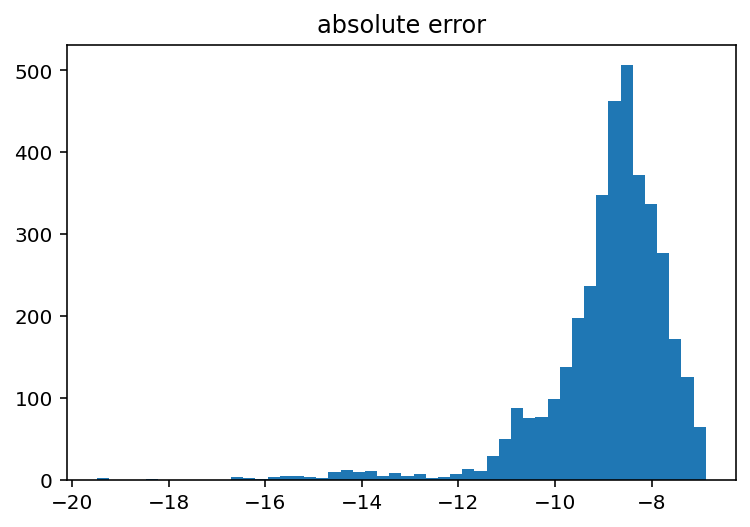

In [29]:
# BJM: Compare sparse hmatrix and direct block model solutions
abserr = np.abs(lsmr_sparse_soln - estimation.state_vector)
relerr = abserr / estimation.state_vector
plt.figure()
plt.title('relative error')
plt.hist(np.log10(relerr),bins=50)
plt.figure()
plt.title('absolute error')
plt.hist(np.log10(abserr),bins=50)
plt.show()

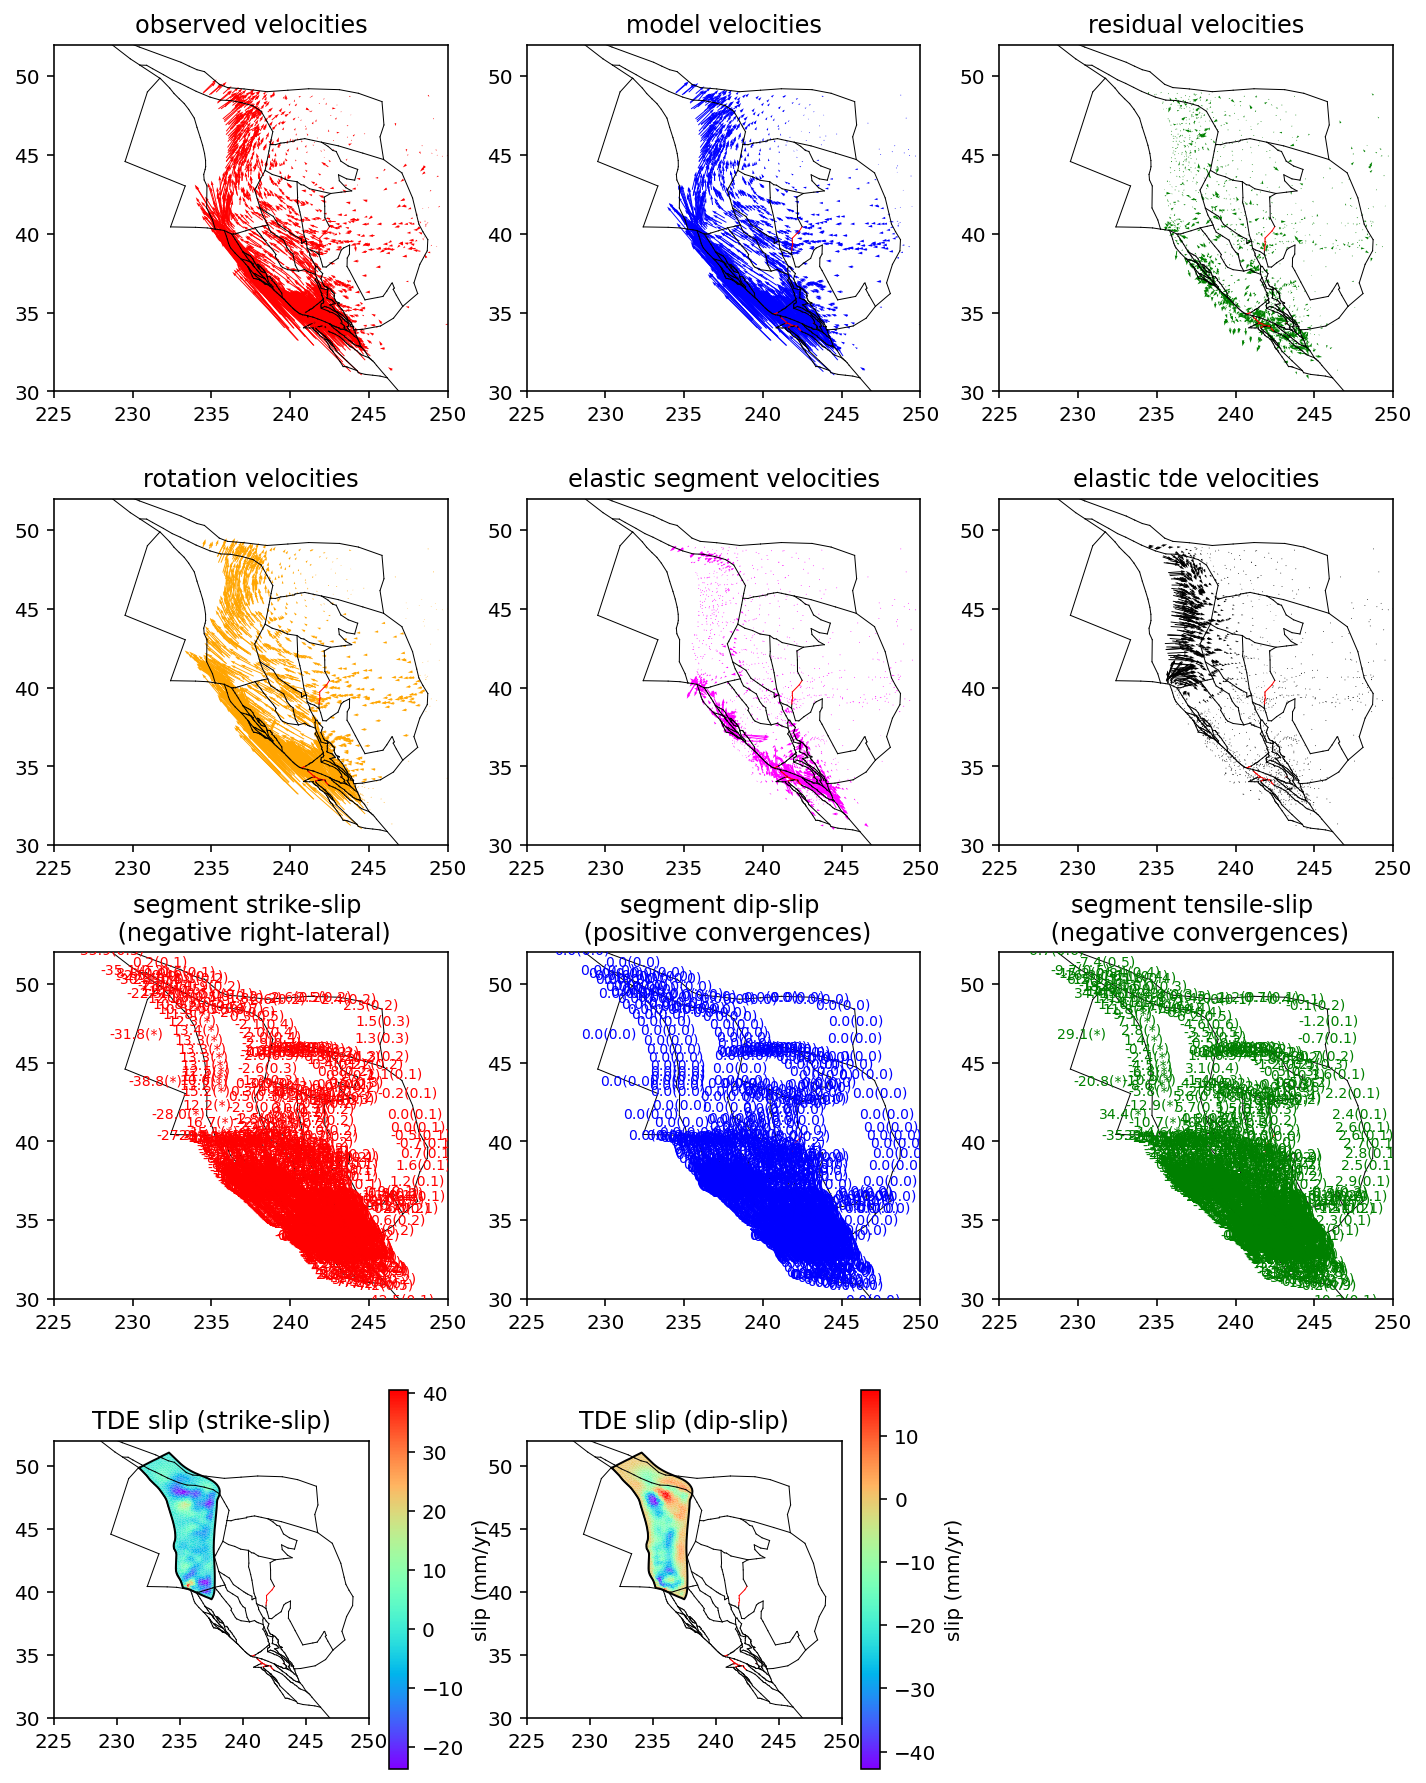

In [30]:
# BJM: Creast copies of state vector and plot block model results
orig_state_vector = estimation.state_vector.copy()
estimation.state_vector = lsmr_sparse_soln
celeri.plot_estimation_summary(segment, station, meshes, estimation, lon_range=(225, 250), lat_range=(30, 52), quiver_scale=1e2)
estimation.state_vector = orig_state_vector